In [1]:
import numpy as np
import time
from pyDOE import lhs
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
import scipy.io
import random
import torch
import torch.optim as optim
import torch.nn as nn

In [2]:
class MultiLayerPerceptronClass(nn.Module):
    """_summary_
    MultiLayerPerceptron
    
    This class is a simple implementation of a multi-layer perceptron (MLP) using PyTorch
    """
    def __init__(
        self,
        name        = 'mlp',
        x_dim       = 784,
        h_dim_list  = [256,256],
        y_dim       = 10,
        actv        = nn.ReLU(),
        p_drop      = 0.2,
        batch_norm  = True,
        output_list = False
    ):
        """
            Initialize MLP
        """
        super(MultiLayerPerceptronClass,self).__init__()
        name       = name
        self.x_dim      = x_dim
        self.h_dim_list = h_dim_list
        self.y_dim      = y_dim
        self.actv       = actv
        self.p_drop     = p_drop
        self.batch_norm = batch_norm
        self.output_list= output_list
        
        # Declare layers
        self.layer_list = []
        h_dim_prev = self.x_dim
        for h_dim in self.h_dim_list:
            # dense -> batchnorm -> actv -> dropout
            self.layer_list.append(nn.Linear(h_dim_prev,h_dim))
            if self.batch_norm: self.layer_list.append(nn.BatchNorm1d(num_features=h_dim))
            self.layer_list.append(self.actv)
            self.layer_list.append(nn.Dropout1d(p=self.p_drop))
            h_dim_prev = h_dim
        self.layer_list.append(nn.Linear(h_dim_prev,self.y_dim))
        
        # Define net
        self.net = nn.Sequential()
        self.layer_names = []
        for l_idx,layer in enumerate(self.layer_list):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.layer_names.append(layer_name)
            self.net.add_module(layer_name,layer)
        
        # Initialize parameters
        self.init_param(VERBOSE=False)
        
    def init_param(self,VERBOSE=False):
        """
            Initialize parameters
        """
        for m_idx,m in enumerate(self.modules()):
            if VERBOSE:
                print ("[%02d]"%(m_idx))
            if isinstance(m,nn.BatchNorm1d): # init BN
                nn.init.constant_(m.weight,1.0)
                nn.init.constant_(m.bias,0.0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
        
    def forward(self,x):
        """
            Forward propagate
        """

        if self.output_list:
            intermediate_output_list = []
            for idx, layer in enumerate(self.net):
                x = layer(x)
                intermediate_output_list.append(x)
            # Final output
            final_output = x   
            return final_output, intermediate_output_list
        
        else:
            for idx, layer in enumerate(self.net):
                x = layer(x)
            # Final output
            final_output = x
            return final_output

In [3]:

# Hyper-parameters
# Partial differential equation configuration
RHO = 1.0  # 밀도
MU = 0.02 # 점성
X0, X1 = 0.0, 1.1 # X Domain
Y0, Y1 = 0.0, 0.41 # Y Domain
INITAL_VEL = 1.0 # 초기속도
# Network configuration
MLP_input = 2
MLP_output = 5
MLP_hidden = 8*[40]
UV_MODEL_PATH = None # 'models/uv_model.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Domain bounds
lb = np.array([X0, Y0])
ub = np.array([X1, Y1])

# WALL = [x, y], u=v=0
wall_up = [X0, Y1] + [X1, Y0] * lhs(2, 441)
wall_lw = [X0, Y0] + [X1, Y0] * lhs(2, 441)

# INLET = [x, y, u, v]
U_max = INITAL_VEL
INLET = [X0, Y0] + [X0, Y1] * lhs(2, 201)
y_INLET = INLET[:,1:2]
u_INLET = 4*U_max*y_INLET*(Y1-y_INLET)/(Y1**2)
v_INLET = 0*y_INLET
INLET = np.concatenate((INLET, u_INLET, v_INLET), 1)

# plt.scatter(INLET[:, 1:2], INLET[:, 2:3], marker='o', alpha=0.2, color='red')
# plt.title("Initial Speed vs. y")
# plt.show()

# INLET = [x, y], p=0
OUTLET = [X1, Y0] + [X0, Y1] * lhs(2, 201)

# Cylinder surface
r = 0.05
theta = [0.0] + [2*np.pi] * lhs(1, 251)
x_CYLD = np.multiply(r, np.cos(theta))+0.2
y_CYLD = np.multiply(r, np.sin(theta))+0.2
CYLD = np.concatenate((x_CYLD, y_CYLD), 1)

WALL = np.concatenate((CYLD, wall_up, wall_lw), 0)

# Collocation point for equation residual
def DelCylPT(XY_c, xc=0.0, yc=0.0, r=0.1):
    '''
    delete points within cylinder
    '''
    dst = np.array([((xy[0] - xc) ** 2 + (xy[1] - yc) ** 2) ** 0.5 for xy in XY_c])
    return XY_c[dst>r,:]


XY_c = lb + (ub - lb) * lhs(2, 40000)
XY_c_refine = [0.1, 0.1] + [0.2, 0.2] * lhs(2, 10000)
XY_c = np.concatenate((XY_c, XY_c_refine), 0)
XY_c = DelCylPT(XY_c, xc=0.2, yc=0.2, r=0.05)
X_c = XY_c[:, 0:1]
Y_c = XY_c[:, 1:2]

print(XY_c.shape)
print(WALL.shape)
print(CYLD.shape)
print(OUTLET.shape)

# # Visualize the collocation points
# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# plt.scatter(X_c, Y_c, marker='o', alpha=0.1 ,color='blue')
# plt.scatter(WALL[:,0:1], WALL[:,1:2], marker='o', alpha=0.2 , color='green')
# plt.scatter(OUTLET[:, 0:1], OUTLET[:, 1:2], marker='o', alpha=0.2, color='orange')
# plt.scatter(INLET[:, 0:1], INLET[:, 1:2], marker='o', alpha=0.2, color='red')
# plt.show()

(47365, 2)
(1133, 2)
(251, 2)
(201, 2)


In [4]:
lb = torch.tensor(lb, dtype=torch.float32).to(device)
ub = torch.tensor(ub, dtype=torch.float32).to(device)

# 물리적 상수
rho = RHO  # 밀도
mu = MU  # 점성

# Collocation points, INLET, OUTLET, WALL을 텐서로 변환
X_c = torch.tensor(X_c, dtype=torch.float32, requires_grad=True).to(device)
Y_c = torch.tensor(Y_c, dtype=torch.float32, requires_grad=True).to(device)
INLET = torch.tensor(INLET, dtype=torch.float32, requires_grad=True).to(device)
OUTLET = torch.tensor(OUTLET, dtype=torch.float32, requires_grad=True).to(device)
WALL = torch.tensor(WALL, dtype=torch.float32, requires_grad=True).to(device)

# 신경망 구성
uv_net = MultiLayerPerceptronClass(
    x_dim=MLP_input, # for x, y
    h_dim_list=MLP_hidden, # hidden layers dimensions
    y_dim=MLP_output, # for u, v, p, s11, s22, s12
    actv=nn.Tanh(),
    p_drop=0.0,
    batch_norm=False,
    output_list=False
)
if UV_MODEL_PATH is not None:
    uv_net.load_state_dict(torch.load(UV_MODEL_PATH))

uv_net = uv_net.to(device)

# 손실 기록
loss_rec = []

def net_uv(x, y):
    """Calculate the predicted values for u, v, p, s11, s22, s12 based on the given input x and y.

    Args:
        x (torch.Tensor): The input tensor for x.
        y (torch.Tensor): The input tensor for y.

    Returns:
        torch.Tensor: The predicted values for u.
        torch.Tensor: The predicted values for v.
        torch.Tensor: The predicted values for p.
        torch.Tensor: The predicted values for s11.
        torch.Tensor: The predicted values for s22.
        torch.Tensor: The predicted values for s12.
    """
    # Implementation based on self.forward
    xy = torch.cat([x, y], dim=1)  # Concatenate the input data
    uv_pred = uv_net(xy)  # Perform prediction using the modified MLP

    # Separate u, v, p, s11, s22, s12 values from uv_pred
    psi = uv_pred[:,0:1]
    p = uv_pred[:,1:2]
    s11 = uv_pred[:, 2:3]
    s22 = uv_pred[:, 3:4]
    s12 = uv_pred[:, 4:5]
    
    # Calculate the derivatives for u and v using automatic differentiation in PyTorch
    u = torch.autograd.grad(psi.sum(), y, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
    # Using .sum() converts the derivative for vector output to scalar for calculation purposes,
    # and there is no grad_outputs=torch.ones_like(...) part because by default, the weight is assumed to be 1 when calculating the derivative for a scalar.
    return u, v, p, s11, s22, s12


def net_f(x, y):
    """Calculate the residual functions based on physical constraints.

    Args:
        x (torch.Tensor): The input tensor for x-coordinate.
        y (torch.Tensor): The input tensor for y-coordinate.

    Returns:
        Tuple[torch.Tensor]: A tuple containing the residual functions f_u, f_v, f_s11, f_s22, f_s12, f_p, and uvp_pred[:3].
    """
    # Implementation based on physical constraints
    # 먼저 net_uv를 호출하여 필요한 값들을 계산합니다.
    u, v, p, s11, s22, s12 = net_uv(x, y)

    # 자동 미분을 사용하여 미분을 계산합니다.
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    s11_x = torch.autograd.grad(s11, x, grad_outputs=torch.ones_like(s11), create_graph=True)[0]
    s12_y = torch.autograd.grad(s12, y, grad_outputs=torch.ones_like(s12), create_graph=True)[0]
    s22_y = torch.autograd.grad(s22, y, grad_outputs=torch.ones_like(s22), create_graph=True)[0]
    s12_x = torch.autograd.grad(s12, x, grad_outputs=torch.ones_like(s12), create_graph=True)[0]

    # 물리적 조건을 바탕으로 한 손실 함수 계산
    f_u = rho * (u * u_x + v * u_y) - (s11_x + s12_y)
    f_v = rho * (u * v_x + v * v_y) - (s12_x + s22_y)
    f_s11 = -p + 2 * mu * u_x - s11
    f_s22 = -p + 2 * mu * v_y - s22
    f_s12 = mu * (u_y + v_x) - s12

    f_p = p + (s11 + s22) / 2

    return f_u, f_v, f_s11, f_s22, f_s12, f_p, (u, v, p)

def loss_fn(X_c, Y_c, INLET, OUTLET, WALL):
    # ----------------------------------------
    # ------------ Loss function -------------
    # ----------------------------------------

    # 물리적 손실 계산
    f_u, f_v, f_s11, f_s22, f_s12, f_p, (u, v, p) = net_f(X_c, Y_c)

    # 경계 조건 손실 계산
    u_INLET, v_INLET, _, _, _, _ = net_uv(INLET[:, 0:1], INLET[:, 1:2])
    _, _, p_OUTLET, _, _, _ = net_uv(OUTLET[:, 0:1], OUTLET[:, 1:2])
    u_WALL, v_WALL, _, _, _, _ = net_uv(WALL[:, 0:1], WALL[:, 1:2])

    # 물리적 손실
    loss_f = torch.mean(f_u**2 + f_v**2 + f_s11**2 + f_s22**2 + f_s12**2 + f_p**2)
    
    # 실제 경계 조건과의 차이를 기반으로 손실 계산
    loss_INLET = torch.mean((u_INLET - INLET[:, 2:3])**2 + (v_INLET - INLET[:, 3:4])**2)
    loss_WALL = torch.mean(u_WALL**2 + v_WALL**2)  # WALL에서는 u, v가 0이어야 함
    loss_OUTLET = torch.mean((p_OUTLET - torch.zeros_like(p_OUTLET))**2)  # OUTLET에서는 p가 0이어야 함

    # 총 손실: 물리적 손실 + 경계 조건 손실
    total_loss = loss_f + 2*(loss_INLET + loss_WALL + loss_OUTLET)
    return total_loss, (u, v, p)

In [5]:

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Early stops the training if validation loss doesn't improve after a given patience.
        :param patience: (int) How long to wait after last time validation loss improved.
                         Default: 7
        :param verbose: (bool) If True, prints a message for each validation loss improvement.
                        Default: False
        :param delta: (float) Minimum change in the monitored quantity to qualify as an improvement.
                      Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # 여기서 모델을 저장합니다. 예: torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

def train(net_uv, X_c, Y_c, INLET, OUTLET, WALL):
    optimizer_adam = optim.Adam(net_uv.parameters(),
                                lr=0.001)
    optimizer_lbfgs = optim.LBFGS(net_uv.parameters(),
                                    lr=1,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=50,
                                    tolerance_grad=1e-05,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
    def closure():
        optimizer_lbfgs.zero_grad()
        total_loss, _ = loss_fn(X_c, Y_c, INLET, OUTLET, WALL)
        total_loss.backward()
        if closure.counter % 100 == 0:
            print(f'LBFGS Iteration {closure.counter}, Loss: {total_loss.item()}')
        closure.counter += 1
        return total_loss
    
    closure.counter = 0
    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    # Adam을 사용한 학습
    for epoch in range(500):
        uv_net.train()
        optimizer_adam.zero_grad()  # 그래디언트 초기화
        total_loss, _ = loss_fn(X_c, Y_c, INLET, OUTLET, WALL)  # 손실 계산
        total_loss.backward()  # 역전파
        optimizer_adam.step()  # 옵티마이저 스텝
        early_stopping(total_loss)
        # print(f'Epoch {epoch+1}, Loss with Adam: {total_loss.item()}')
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    optimizer_lbfgs.step(closure)  # closure 함수를 호출하여 손실 계산 및 역전파 수행
    with torch.no_grad():
        total_loss, _ = loss_fn(X_c, Y_c, INLET, OUTLET, WALL)
        print(f'Epoch {epoch+1}, Loss with L-BFGS: {total_loss.item()}')
            

In [6]:
start_time = time.time()
print("Starting training...")
train(uv_net, X_c, Y_c, INLET, OUTLET, WALL)
print("--- %s seconds ---" % (time.time() - start_time))

Starting training...
Validation loss decreased (inf --> 12207.991211).  Saving model ...
Validation loss decreased (12207.991211 --> 69.346291).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
Validation loss decreased (69.346291 --> 43.088142).  Saving model ...
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
Validation loss decreased (43.088142 --> 41.744190).  Saving model ...
Validation loss decreased (41.744190 --> 33.906841).  Saving model ...
Validation loss decreased (33.906841 --> 27.636459).  Saving mod

KeyboardInterrupt: 

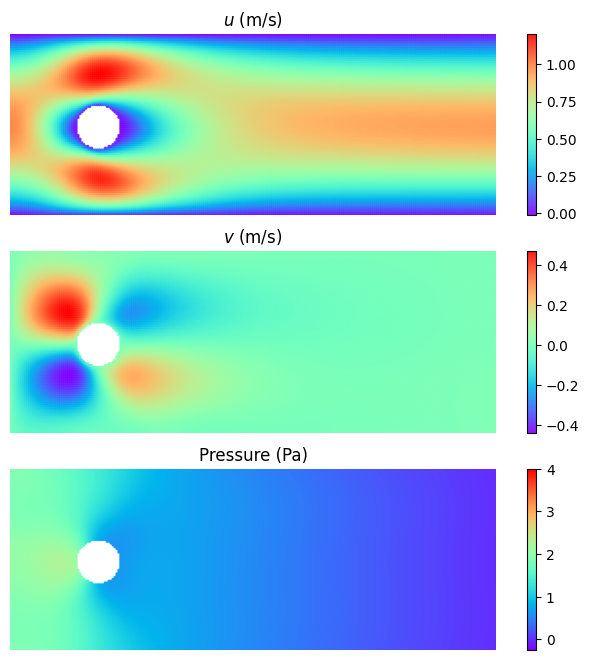

In [17]:
def postProcess(xmin, xmax, ymin, ymax, field_MIXED, s=2, alpha=0.5, marker='o'):

    [x_MIXED, y_MIXED, u_MIXED, v_MIXED, p_MIXED] = field_MIXED

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    # Plot MIXED result
    cf = ax[0].scatter(x_MIXED, y_MIXED, c=u_MIXED, alpha=alpha-0.1, edgecolors='none', cmap='rainbow', marker=marker, s=int(s))
    ax[0].axis('square')
    for key, spine in ax[0].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlim([xmin, xmax])
    ax[0].set_ylim([ymin, ymax])
    # cf.cmap.set_under('whitesmoke')
    # cf.cmap.set_over('black')
    ax[0].set_title(r'$u$ (m/s)')
    fig.colorbar(cf, ax=ax[0], fraction=0.046, pad=0.04)

    cf = ax[1].scatter(x_MIXED, y_MIXED, c=v_MIXED, alpha=alpha-0.1, edgecolors='none', cmap='rainbow', marker=marker, s=int(s))
    ax[1].axis('square')
    for key, spine in ax[1].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xlim([xmin, xmax])
    ax[1].set_ylim([ymin, ymax])
    # cf.cmap.set_under('whitesmoke')
    # cf.cmap.set_over('black')
    ax[1].set_title(r'$v$ (m/s)')
    fig.colorbar(cf, ax=ax[1], fraction=0.046, pad=0.04)

    cf = ax[2].scatter(x_MIXED, y_MIXED, c=p_MIXED, alpha=alpha, edgecolors='none', cmap='rainbow', marker=marker, s=int(s), vmin=-0.25, vmax=4.0)
    ax[2].axis('square')
    for key, spine in ax[2].spines.items():
        if key in ['right','top','left','bottom']:
            spine.set_visible(False)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_xlim([xmin, xmax])
    ax[2].set_ylim([ymin, ymax])
    # cf.cmap.set_under('whitesmoke')
    # cf.cmap.set_over('black')
    ax[2].set_title('Pressure (Pa)')
    fig.colorbar(cf, ax=ax[2], fraction=0.046, pad=0.04)

    plt.savefig('./uvp.png', dpi=1000)
    plt.show()
    plt.close('all')

x_PINN = np.linspace(0, 1.1, 251)
y_PINN = np.linspace(0, 0.41, 101)
x_PINN, y_PINN = np.meshgrid(x_PINN, y_PINN)
x_PINN = x_PINN.flatten()[:, None]
y_PINN = y_PINN.flatten()[:, None]
dst = ((x_PINN-0.2)**2+(y_PINN-0.2)**2)**0.5
x_PINN = x_PINN[dst >= 0.05]
y_PINN = y_PINN[dst >= 0.05]
x_PINN = x_PINN.flatten()[:, None]
y_PINN = y_PINN.flatten()[:, None]
x_PINN = torch.tensor(x_PINN, dtype=torch.float32, requires_grad=True)
y_PINN = torch.tensor(y_PINN, dtype=torch.float32, requires_grad=True)

uv_net = uv_net.to('cpu')
u_PINN, v_PINN, p_PINN, _, _, _ = net_uv(x_PINN, y_PINN)

x_PINN = x_PINN.cpu().detach().numpy()
y_PINN = y_PINN.cpu().detach().numpy()
u_PINN = u_PINN.cpu().detach().numpy()
v_PINN = v_PINN.cpu().detach().numpy()
p_PINN = p_PINN.cpu().detach().numpy()

field_MIXED = [x_PINN, y_PINN, u_PINN, v_PINN, p_PINN]

postProcess(xmin=0, xmax=1.1, ymin=0, ymax=0.41, field_MIXED=field_MIXED, s=5, alpha=1)